### Defining a network for experimentation

To perform the experiments with algorithms described in *On the Convergence of Single-Call Stochastic Extra-Gradient Methods*, we first need to construct a Generative Adversarial Network. Since in the paper the specifics of the experiments are not mentioned, we can define the GAN arbitrarily.

In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt

torch.manual_seed(111)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

First, we will define the **discriminator** - a neural network that takes an input, typically an image, and outputs a probability indicating whether the input is real or generated by the generator. The primary goal of the discriminator is to distinguish between real and fake samples.

The defined discriminator has the following structure:
1. **Input Size**: The discriminator expects an input tensor with a shape of (batch_size, 784). This assumes that the input represents flattened images of size 28x28 (format of the MNIST dataset).

2. **Sequential Model**: The core of the discriminator is defined as a nn.Sequential module, consisting of several linear layers, ReLU activation functions, dropout layers, and a final sigmoid activation.

3. **Linear Layers with ReLU Activation**: The linear layers are responsible for learning complex representations of the input. The ReLU activation functions introduce non-linearity to the model, allowing it to capture intricate patterns in the data.

4. **Dropout Layers**: Dropout layers (with a dropout probability of 0.3) are included to prevent overfitting during training. Dropout randomly sets a fraction of input units to zero during each update, which helps prevent the model from relying too much on specific features.

5. **Output Layer with Sigmoid Activation**: The last linear layer with a sigmoid activation produces a single output, representing the probability that the input is a real sample. The sigmoid activation ensures that the output is in the range [0, 1], where values close to 1 indicate a high probability of being a real sample, and values close to 0 indicate a high probability of being a generated sample.

6. **Forward Method**: The forward method reshapes the input tensor (x) and passes it through the layers defined in the Sequential model, producing the final output.

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

discriminator = Discriminator().to(device=device)

Then, we define the **generator** - a neural network that takes random noise as input and generates synthetic samples that ideally resemble real samples from the training dataset. The generator's objective is to produce realistic data that can deceive the discriminator.

The defined generator has the following structure:

1. **Input Size**: The generator takes a random noise vector as input, usually represented as a tensor of size (batch_size, 100). This noise is sampled from a probability distribution (often Gaussian).

2. **Sequential Model**: The generator is defined as a nn.Sequential module, consisting of several linear layers with ReLU activations and a final linear layer with a tanh activation.

3. **Linear Layers with ReLU Activation**: The linear layers gradually upsample the input noise, transforming it into a higher-dimensional representation. ReLU activation functions introduce non-linearity, allowing the model to learn complex mappings from noise to realistic data.

4. **Output Layer with Tanh Activation**: The last linear layer has a tanh activation function. Tanh squashes the output values to the range [-1, 1]. This is commonly used when the data represents pixel values (e.g., images) because it ensures that the generator's output is within the same range as the real data.

5. **Reshaping Output**: The output tensor is reshaped to have dimensions (batch_size, 1, 28, 28). This is suitable for representing images with a shape of 28x28 pixels.

6. **Forward Method**: The forward method takes the input noise tensor (x) and passes it through the layers defined in the Sequential model. The final output is reshaped to match the dimensions of an image.

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

### Model training

First, we set up hyperparameters and different optimizers for the generator and the discriminator.

In [4]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [5]:
# Hyperparameters
batch_size = 64
num_generator_updates = 500000
lr_generator = 2e-4
lr_discriminator = 2e-4
adam_beta1 = 0.5
adam_beta2 = 0.999

# Optimizers
optimizer_generator = optim.Adam(generator.parameters(), lr=lr_generator, betas=(adam_beta1, adam_beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(adam_beta1, adam_beta2))

The dataset used in experimentation is MNIST dataset. The dataset consists of a collection of 28x28 pixel grayscale images of handwritten digits (0 through 9) along with their corresponding labels. Each image is a single-channel (grayscale) image, and the pixels represent the intensity of the digits.

100%|██████████| 9912422/9912422 [00:00<00:00, 134216509.38it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 108641877.87it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47155948.43it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19948197.66it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



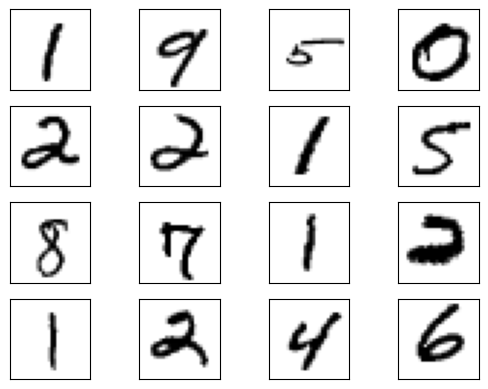

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

The algorithm that is investigated in this paper is the Extra-Gradient Algorithm. The essence of the Extra-Gradient Descent (EGD) algorithm lies in its two-step optimization process, where it uses an inner loop to compute the gradients of the gradients (extra gradients). The algorithm works as follows:

1. **Inner Loop (First Gradient Step)** - given the current parameters of a model, perform a standard gradient descent step to minimize the loss with respect to the model's parameters. This is the typical update step used in standard gradient descent.

2. **Compute Extra Gradients (Second Gradient Step)** - with the updated parameters obtained from the first step, compute the gradients of the loss with respect to the model's parameters again. These gradients are referred to as "extra gradients."

3. **Outer Loop (Update Parameters)** - update the model's parameters using the computed extra gradients. This step considers the additional information provided by the extra gradients to further refine the model parameters.

4. **Repeat** - iterate between steps 1 to 3 until convergence or for a specified number of iterations.


#### First training loop

To estimate how well the GAN would train without the Extra-Gradient algorithm, first we launch the training without implementing any algorithm for changing the way the weights are modified.

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 Loss D.: 0.6963329315185547
Epoch: 0 Loss G.: 0.7267425060272217


  2%|▏         | 1/50 [00:24<20:01, 24.52s/it]

Epoch: 1 Loss D.: 0.42085063457489014
Epoch: 1 Loss G.: 12.580062866210938


  4%|▍         | 2/50 [00:48<19:30, 24.39s/it]

Epoch: 2 Loss D.: 0.05074866861104965
Epoch: 2 Loss G.: 4.158966064453125


  6%|▌         | 3/50 [01:13<19:11, 24.51s/it]

Epoch: 3 Loss D.: 7.568624278064817e-05
Epoch: 3 Loss G.: 12.810401916503906


  8%|▊         | 4/50 [01:37<18:47, 24.50s/it]

Epoch: 4 Loss D.: 1.8671315604734673e-09
Epoch: 4 Loss G.: 37.27173614501953


 10%|█         | 5/50 [02:02<18:18, 24.42s/it]

Epoch: 5 Loss D.: 1.862645371275562e-09
Epoch: 5 Loss G.: 68.28955078125


 12%|█▏        | 6/50 [02:26<17:54, 24.41s/it]

Epoch: 6 Loss D.: 4.7937101902574214e-23
Epoch: 6 Loss G.: 59.933349609375


 14%|█▍        | 7/50 [02:50<17:28, 24.39s/it]

Epoch: 7 Loss D.: 1.1956753582786232e-20
Epoch: 7 Loss G.: 63.218360900878906


 16%|█▌        | 8/50 [03:15<17:01, 24.32s/it]

Epoch: 8 Loss D.: 4.056879899772146e-22
Epoch: 8 Loss G.: 59.569580078125


 18%|█▊        | 9/50 [03:39<16:36, 24.30s/it]

Epoch: 9 Loss D.: 5.390987308119144e-19
Epoch: 9 Loss G.: 57.914817810058594


 20%|██        | 10/50 [04:03<16:08, 24.21s/it]

Epoch: 10 Loss D.: 1.562444915439163e-16
Epoch: 10 Loss G.: 55.91845703125


 22%|██▏       | 11/50 [04:27<15:40, 24.13s/it]

Epoch: 11 Loss D.: 5.587936335871291e-09
Epoch: 11 Loss G.: 100.0


 24%|██▍       | 12/50 [04:51<15:16, 24.12s/it]

Epoch: 12 Loss D.: 0.0
Epoch: 12 Loss G.: 100.0


 26%|██▌       | 13/50 [05:15<14:54, 24.17s/it]

Epoch: 13 Loss D.: 0.0
Epoch: 13 Loss G.: 100.0


 28%|██▊       | 14/50 [05:39<14:28, 24.12s/it]

Epoch: 14 Loss D.: 0.0
Epoch: 14 Loss G.: 100.0


 30%|███       | 15/50 [06:03<14:04, 24.13s/it]

Epoch: 15 Loss D.: 0.0
Epoch: 15 Loss G.: 100.0


 32%|███▏      | 16/50 [06:27<13:39, 24.10s/it]

Epoch: 16 Loss D.: 0.0
Epoch: 16 Loss G.: 100.0


 34%|███▍      | 17/50 [06:51<13:14, 24.07s/it]

Epoch: 17 Loss D.: 0.0
Epoch: 17 Loss G.: 100.0


 36%|███▌      | 18/50 [07:15<12:49, 24.05s/it]

Epoch: 18 Loss D.: 0.0
Epoch: 18 Loss G.: 100.0


 38%|███▊      | 19/50 [07:40<12:27, 24.11s/it]

Epoch: 19 Loss D.: 0.0
Epoch: 19 Loss G.: 100.0


 40%|████      | 20/50 [08:04<12:03, 24.11s/it]

Epoch: 20 Loss D.: 0.0
Epoch: 20 Loss G.: 100.0


 42%|████▏     | 21/50 [08:28<11:39, 24.11s/it]

Epoch: 21 Loss D.: 0.0
Epoch: 21 Loss G.: 100.0


 44%|████▍     | 22/50 [08:52<11:16, 24.15s/it]

Epoch: 22 Loss D.: 0.0
Epoch: 22 Loss G.: 99.62643432617188


 46%|████▌     | 23/50 [09:16<10:53, 24.19s/it]

Epoch: 23 Loss D.: 0.0
Epoch: 23 Loss G.: 100.0


 48%|████▊     | 24/50 [09:40<10:27, 24.12s/it]

Epoch: 24 Loss D.: 0.0
Epoch: 24 Loss G.: 100.0


 50%|█████     | 25/50 [10:04<10:00, 24.04s/it]

Epoch: 25 Loss D.: 0.0
Epoch: 25 Loss G.: 100.0


 52%|█████▏    | 26/50 [10:28<09:37, 24.05s/it]

Epoch: 26 Loss D.: 0.0
Epoch: 26 Loss G.: 100.0


 54%|█████▍    | 27/50 [10:52<09:12, 24.03s/it]

Epoch: 27 Loss D.: 0.0
Epoch: 27 Loss G.: 100.0


 56%|█████▌    | 28/50 [11:16<08:48, 24.00s/it]

Epoch: 28 Loss D.: 0.0
Epoch: 28 Loss G.: 100.0


 58%|█████▊    | 29/50 [11:40<08:23, 24.00s/it]

Epoch: 29 Loss D.: 0.0
Epoch: 29 Loss G.: 100.0


 60%|██████    | 30/50 [12:04<08:00, 24.01s/it]

Epoch: 30 Loss D.: 0.0
Epoch: 30 Loss G.: 100.0


 62%|██████▏   | 31/50 [12:28<07:36, 24.05s/it]

Epoch: 31 Loss D.: 0.0
Epoch: 31 Loss G.: 100.0


 64%|██████▍   | 32/50 [12:52<07:13, 24.07s/it]

Epoch: 32 Loss D.: 4.6514577910533117e-38
Epoch: 32 Loss G.: 100.0


 66%|██████▌   | 33/50 [13:17<06:51, 24.23s/it]

Epoch: 33 Loss D.: 0.0
Epoch: 33 Loss G.: 99.49022674560547


 68%|██████▊   | 34/50 [13:41<06:27, 24.24s/it]

Epoch: 34 Loss D.: 0.0
Epoch: 34 Loss G.: 100.0


 70%|███████   | 35/50 [14:06<06:03, 24.22s/it]

Epoch: 35 Loss D.: 0.0
Epoch: 35 Loss G.: 100.0


 72%|███████▏  | 36/50 [14:30<05:39, 24.26s/it]

Epoch: 36 Loss D.: 0.0
Epoch: 36 Loss G.: 100.0


 74%|███████▍  | 37/50 [14:54<05:15, 24.24s/it]

Epoch: 37 Loss D.: 0.0
Epoch: 37 Loss G.: 100.0


 76%|███████▌  | 38/50 [15:18<04:51, 24.27s/it]

Epoch: 38 Loss D.: 0.0
Epoch: 38 Loss G.: 100.0


 78%|███████▊  | 39/50 [15:43<04:27, 24.32s/it]

Epoch: 39 Loss D.: 6.285201963082172e-40
Epoch: 39 Loss G.: 100.0


 80%|████████  | 40/50 [16:07<04:04, 24.40s/it]

Epoch: 40 Loss D.: 0.0
Epoch: 40 Loss G.: 100.0


 82%|████████▏ | 41/50 [16:32<03:39, 24.42s/it]

Epoch: 41 Loss D.: 0.0
Epoch: 41 Loss G.: 100.0


 84%|████████▍ | 42/50 [16:56<03:14, 24.34s/it]

Epoch: 42 Loss D.: 0.0
Epoch: 42 Loss G.: 100.0


 86%|████████▌ | 43/50 [17:21<02:50, 24.42s/it]

Epoch: 43 Loss D.: 0.0
Epoch: 43 Loss G.: 100.0


 88%|████████▊ | 44/50 [17:45<02:26, 24.40s/it]

Epoch: 44 Loss D.: 0.0
Epoch: 44 Loss G.: 100.0


 90%|█████████ | 45/50 [18:09<02:01, 24.34s/it]

Epoch: 45 Loss D.: 1.0427342132733829e-40
Epoch: 45 Loss G.: 100.0


 92%|█████████▏| 46/50 [18:34<01:37, 24.41s/it]

Epoch: 46 Loss D.: 0.0
Epoch: 46 Loss G.: 100.0


 94%|█████████▍| 47/50 [18:58<01:13, 24.37s/it]

Epoch: 47 Loss D.: 0.0
Epoch: 47 Loss G.: 100.0


 96%|█████████▌| 48/50 [19:22<00:48, 24.35s/it]

Epoch: 48 Loss D.: 0.0
Epoch: 48 Loss G.: 100.0


 98%|█████████▊| 49/50 [19:47<00:24, 24.41s/it]

Epoch: 49 Loss D.: 0.0
Epoch: 49 Loss G.: 99.63421630859375


100%|██████████| 50/50 [20:11<00:00, 24.24s/it]


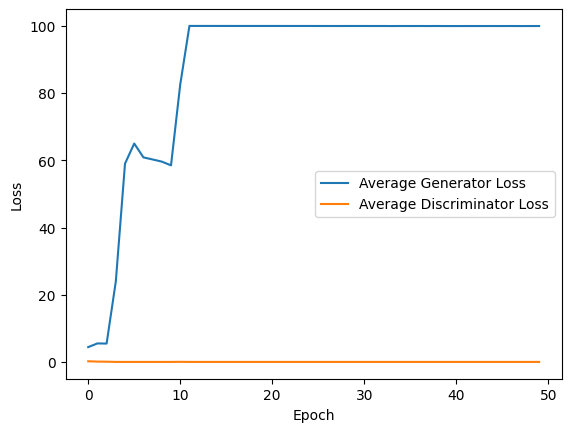

In [ ]:
# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_generator = optim.Adam(generator.parameters(), lr=lr_generator, betas=(adam_beta1, adam_beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(adam_beta1, adam_beta2))

from tqdm import tqdm

# Lists to store losses
average_generator_losses = []
average_discriminator_losses = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    generator_epoch_losses = []
    discriminator_epoch_losses = []

    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)

        loss_generator.backward()
        optimizer_generator.step()

        # Append losses to epoch lists
        generator_epoch_losses.append(loss_generator.item())
        discriminator_epoch_losses.append(loss_discriminator.item())

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

    # Average losses over the epoch
    average_generator_loss = sum(generator_epoch_losses) / len(generator_epoch_losses)
    average_discriminator_loss = sum(discriminator_epoch_losses) / len(discriminator_epoch_losses)

    # Append average losses to lists
    average_generator_losses.append(average_generator_loss)
    average_discriminator_losses.append(average_discriminator_loss)

# Plot average losses
plt.plot(average_generator_losses, label='Average Generator Loss')
plt.plot(average_discriminator_losses, label='Average Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

As we can see, the discriminator trains extremely fast and therefore generator loss cannot improve.

In [ ]:
# Save the parameters of the generator
torch.save(generator.state_dict(), 'generator_0.pth')

# Save the parameters of the discriminator
torch.save(discriminator.state_dict(), 'discriminator_0.pth')

#### Second training loop

To estimate how well the GAN would train without the Extra-Gradient algorithm, but with artificially decreased learning rate for the discriminator, we decrease it in hopes of giving generator more time to learn to generate good images.

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 Loss D.: 0.6540775895118713
Epoch: 0 Loss G.: 0.8347119092941284


  2%|▏         | 1/50 [00:24<19:52, 24.34s/it]

Epoch: 1 Loss D.: 0.12486381828784943
Epoch: 1 Loss G.: 5.558274745941162


  4%|▍         | 2/50 [00:49<19:45, 24.70s/it]

Epoch: 2 Loss D.: 0.1581731140613556
Epoch: 2 Loss G.: 4.681067943572998


  6%|▌         | 3/50 [01:13<19:17, 24.62s/it]

Epoch: 3 Loss D.: 0.031100083142518997
Epoch: 3 Loss G.: 4.828187942504883


  8%|▊         | 4/50 [01:38<18:57, 24.72s/it]

Epoch: 4 Loss D.: 4.470354753038919e-08
Epoch: 4 Loss G.: 55.76262283325195


 10%|█         | 5/50 [02:03<18:31, 24.69s/it]

Epoch: 5 Loss D.: 2.302043437939923e-18
Epoch: 5 Loss G.: 52.835105895996094


 12%|█▏        | 6/50 [02:27<18:06, 24.68s/it]

Epoch: 6 Loss D.: 1.751138466274827e-14
Epoch: 6 Loss G.: 45.57477569580078


 14%|█▍        | 7/50 [02:52<17:43, 24.74s/it]

Epoch: 7 Loss D.: 5.3749465066260576e-40
Epoch: 7 Loss G.: 97.9805908203125


 16%|█▌        | 8/50 [03:17<17:17, 24.69s/it]

Epoch: 8 Loss D.: 7.685285064433299e-35
Epoch: 8 Loss G.: 96.707275390625


 18%|█▊        | 9/50 [03:41<16:50, 24.64s/it]

Epoch: 9 Loss D.: 1.151415877188349e-31
Epoch: 9 Loss G.: 98.70329284667969


 20%|██        | 10/50 [04:06<16:24, 24.60s/it]

Epoch: 10 Loss D.: 1.2173290927420988e-34
Epoch: 10 Loss G.: 95.01300048828125


 22%|██▏       | 11/50 [04:30<15:58, 24.57s/it]

Epoch: 11 Loss D.: 3.7252949169896965e-08
Epoch: 11 Loss G.: 95.951904296875


 24%|██▍       | 12/50 [04:55<15:32, 24.54s/it]

Epoch: 12 Loss D.: 1.390846796683892e-31
Epoch: 12 Loss G.: 95.97661590576172


 26%|██▌       | 13/50 [05:20<15:09, 24.58s/it]

Epoch: 13 Loss D.: 4.160174149073407e-34
Epoch: 13 Loss G.: 91.45276641845703


 28%|██▊       | 14/50 [05:45<14:52, 24.79s/it]

Epoch: 14 Loss D.: 5.6004543880546726e-33
Epoch: 14 Loss G.: 92.52732849121094


 30%|███       | 15/50 [06:10<14:28, 24.80s/it]

Epoch: 15 Loss D.: 3.909866773405629e-31
Epoch: 15 Loss G.: 90.6705551147461


 32%|███▏      | 16/50 [06:34<14:02, 24.78s/it]

Epoch: 16 Loss D.: 1.309683143539276e-31
Epoch: 16 Loss G.: 87.80546569824219


 34%|███▍      | 17/50 [07:00<13:40, 24.88s/it]

Epoch: 17 Loss D.: 1.7892653548559043e-32
Epoch: 17 Loss G.: 91.61885070800781


 36%|███▌      | 18/50 [07:25<13:17, 24.93s/it]

Epoch: 18 Loss D.: 1.0132266420966422e-31
Epoch: 18 Loss G.: 88.10301208496094


 38%|███▊      | 19/50 [07:50<12:54, 24.97s/it]

Epoch: 19 Loss D.: 4.0904344606354405e-28
Epoch: 19 Loss G.: 92.68791198730469


 40%|████      | 20/50 [08:14<12:25, 24.85s/it]

Epoch: 20 Loss D.: 6.523407780679246e-31
Epoch: 20 Loss G.: 83.8345947265625


 42%|████▏     | 21/50 [08:39<11:59, 24.82s/it]

Epoch: 21 Loss D.: 3.302394567688817e-31
Epoch: 21 Loss G.: 89.93070983886719


 44%|████▍     | 22/50 [09:04<11:35, 24.84s/it]

Epoch: 22 Loss D.: 6.553718720659267e-29
Epoch: 22 Loss G.: 86.7420883178711


 46%|████▌     | 23/50 [09:29<11:09, 24.80s/it]

Epoch: 23 Loss D.: 6.566515923286612e-29
Epoch: 23 Loss G.: 90.60956573486328


 48%|████▊     | 24/50 [09:53<10:44, 24.78s/it]

Epoch: 24 Loss D.: 5.21354472067661e-29
Epoch: 24 Loss G.: 87.72057342529297


 50%|█████     | 25/50 [10:18<10:17, 24.69s/it]

Epoch: 25 Loss D.: 8.321567873535792e-34
Epoch: 25 Loss G.: 88.14939880371094


 52%|█████▏    | 26/50 [10:42<09:52, 24.69s/it]

Epoch: 26 Loss D.: 1.940043223436796e-32
Epoch: 26 Loss G.: 85.17323303222656


 54%|█████▍    | 27/50 [11:07<09:29, 24.74s/it]

Epoch: 27 Loss D.: 9.343152596380887e-30
Epoch: 27 Loss G.: 88.14610290527344


 56%|█████▌    | 28/50 [11:32<09:04, 24.76s/it]

Epoch: 28 Loss D.: 9.074638888701085e-32
Epoch: 28 Loss G.: 86.2169189453125


 58%|█████▊    | 29/50 [11:57<08:42, 24.87s/it]

Epoch: 29 Loss D.: 2.518339600591481e-30
Epoch: 29 Loss G.: 86.83393096923828


 60%|██████    | 30/50 [12:22<08:16, 24.84s/it]

Epoch: 30 Loss D.: 4.497201938987205e-28
Epoch: 30 Loss G.: 91.79713439941406


 62%|██████▏   | 31/50 [12:47<07:54, 24.98s/it]

Epoch: 31 Loss D.: 1.9056399714965625e-30
Epoch: 31 Loss G.: 86.30378723144531


 64%|██████▍   | 32/50 [13:12<07:29, 24.95s/it]

Epoch: 32 Loss D.: 1.2789173530731705e-30
Epoch: 32 Loss G.: 88.94374084472656


 66%|██████▌   | 33/50 [13:37<07:05, 25.03s/it]

Epoch: 33 Loss D.: 7.071544558049601e-31
Epoch: 33 Loss G.: 91.20864868164062


 68%|██████▊   | 34/50 [14:02<06:39, 24.99s/it]

Epoch: 34 Loss D.: 5.302077989892407e-30
Epoch: 34 Loss G.: 87.37539672851562


 70%|███████   | 35/50 [14:27<06:14, 24.95s/it]

Epoch: 35 Loss D.: 1.3608119168501843e-32
Epoch: 35 Loss G.: 87.40947723388672


 72%|███████▏  | 36/50 [14:52<05:49, 24.93s/it]

Epoch: 36 Loss D.: 7.065781932093565e-33
Epoch: 36 Loss G.: 88.28506469726562


 74%|███████▍  | 37/50 [15:17<05:24, 24.97s/it]

Epoch: 37 Loss D.: 1.5529152120972988e-30
Epoch: 37 Loss G.: 88.9345703125


 76%|███████▌  | 38/50 [15:42<04:59, 24.96s/it]

Epoch: 38 Loss D.: 1.4207122976557986e-28
Epoch: 38 Loss G.: 89.77375030517578


 78%|███████▊  | 39/50 [16:07<04:35, 25.03s/it]

Epoch: 39 Loss D.: 9.173577750284302e-33
Epoch: 39 Loss G.: 86.0604248046875


 80%|████████  | 40/50 [16:32<04:10, 25.02s/it]

Epoch: 40 Loss D.: 5.467269834855271e-31
Epoch: 40 Loss G.: 87.49479675292969


 82%|████████▏ | 41/50 [16:57<03:45, 25.00s/it]

Epoch: 41 Loss D.: 1.025474760027973e-28
Epoch: 41 Loss G.: 89.44661712646484


 84%|████████▍ | 42/50 [17:22<03:20, 25.05s/it]

Epoch: 42 Loss D.: 2.09157717593684e-25
Epoch: 42 Loss G.: 89.72836303710938


 86%|████████▌ | 43/50 [17:48<02:56, 25.16s/it]

Epoch: 43 Loss D.: 1.8655603161109258e-30
Epoch: 43 Loss G.: 82.11588287353516


 88%|████████▊ | 44/50 [18:13<02:31, 25.23s/it]

Epoch: 44 Loss D.: 2.867770695349402e-32
Epoch: 44 Loss G.: 88.4451904296875


 90%|█████████ | 45/50 [18:38<02:06, 25.23s/it]

Epoch: 45 Loss D.: 5.772752924504027e-29
Epoch: 45 Loss G.: 88.71432495117188


 92%|█████████▏| 46/50 [19:04<01:40, 25.21s/it]

Epoch: 46 Loss D.: 6.085455336218246e-29
Epoch: 46 Loss G.: 86.82894897460938


 94%|█████████▍| 47/50 [19:29<01:15, 25.17s/it]

Epoch: 47 Loss D.: 5.748960246460616e-32
Epoch: 47 Loss G.: 89.50115966796875


 96%|█████████▌| 48/50 [19:54<00:50, 25.14s/it]

Epoch: 48 Loss D.: 8.91996205229531e-32
Epoch: 48 Loss G.: 87.72574615478516


 98%|█████████▊| 49/50 [20:19<00:25, 25.15s/it]

Epoch: 49 Loss D.: 2.8565114578089207e-31
Epoch: 49 Loss G.: 86.79525756835938


100%|██████████| 50/50 [20:44<00:00, 24.89s/it]


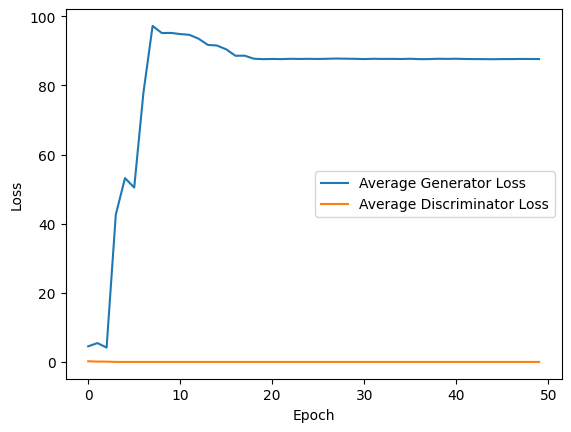

In [ ]:
from tqdm import tqdm

generator = Generator().to(device)
discriminator = Discriminator().to(device)

lr_generator = 0.001
lr_discriminator = 0.0001

# Optimizers
optimizer_generator = optim.Adam(generator.parameters(), lr=lr_generator, betas=(adam_beta1, adam_beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(adam_beta1, adam_beta2))
# Lists to store losses
average_generator_losses = []
average_discriminator_losses = []

# Weighting factor for discriminator loss

# Training loop
for epoch in tqdm(range(num_epochs)):
    generator_epoch_losses = []
    discriminator_epoch_losses = []

    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)

        loss_generator.backward()
        optimizer_generator.step()

        # Append losses to epoch lists
        generator_epoch_losses.append(loss_generator.item())
        discriminator_epoch_losses.append(loss_discriminator.item())

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

    # Average losses over the epoch
    average_generator_loss = sum(generator_epoch_losses) / len(generator_epoch_losses)
    average_discriminator_loss = sum(discriminator_epoch_losses) / len(discriminator_epoch_losses)

    # Append average losses to lists
    average_generator_losses.append(average_generator_loss)
    average_discriminator_losses.append(average_discriminator_loss)

# Plot average losses
plt.plot(average_generator_losses, label='Average Generator Loss')
plt.plot(average_discriminator_losses, label='Average Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Save the parameters of the generator
torch.save(generator.state_dict(), 'generator_1.pth')

# Save the parameters of the discriminator
torch.save(discriminator.state_dict(), 'discriminator_1.pth')

First run with extra gradient method of changing gradients.

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 Loss D.: 0.573490560054779
Epoch: 0 Loss G.: 0.9718191623687744


  2%|▏         | 1/50 [00:33<27:13, 33.33s/it]

Epoch: 1 Loss D.: 0.06440077722072601
Epoch: 1 Loss G.: 5.285574436187744


  4%|▍         | 2/50 [01:06<26:27, 33.08s/it]

Epoch: 2 Loss D.: 0.13833396136760712
Epoch: 2 Loss G.: 3.3529586791992188


  6%|▌         | 3/50 [01:39<25:53, 33.05s/it]

Epoch: 3 Loss D.: 0.11887233704328537
Epoch: 3 Loss G.: 3.7153897285461426


  8%|▊         | 4/50 [02:12<25:22, 33.09s/it]

Epoch: 4 Loss D.: 2.3856465691807216e-09
Epoch: 4 Loss G.: 31.292194366455078


 10%|█         | 5/50 [02:45<24:46, 33.04s/it]

Epoch: 5 Loss D.: 1.4905359171208659e-24
Epoch: 5 Loss G.: 73.58634948730469


 12%|█▏        | 6/50 [03:18<24:15, 33.09s/it]

Epoch: 6 Loss D.: 5.361928453200156e-19
Epoch: 6 Loss G.: 55.46411895751953


 14%|█▍        | 7/50 [03:51<23:42, 33.09s/it]

Epoch: 7 Loss D.: 1.2176220212330613e-17
Epoch: 7 Loss G.: 56.12403869628906


 16%|█▌        | 8/50 [04:24<23:07, 33.04s/it]

Epoch: 8 Loss D.: 0.0
Epoch: 8 Loss G.: 100.0


 18%|█▊        | 9/50 [04:57<22:29, 32.92s/it]

Epoch: 9 Loss D.: 0.0
Epoch: 9 Loss G.: 100.0


 20%|██        | 10/50 [05:30<21:58, 32.97s/it]

Epoch: 10 Loss D.: 0.0
Epoch: 10 Loss G.: 100.0


 22%|██▏       | 11/50 [06:03<21:22, 32.89s/it]

Epoch: 11 Loss D.: 0.0
Epoch: 11 Loss G.: 100.0


 24%|██▍       | 12/50 [06:36<20:52, 32.95s/it]

Epoch: 12 Loss D.: 0.0
Epoch: 12 Loss G.: 100.0


 26%|██▌       | 13/50 [07:09<20:24, 33.09s/it]

Epoch: 13 Loss D.: 0.0
Epoch: 13 Loss G.: 100.0


 28%|██▊       | 14/50 [07:42<19:50, 33.06s/it]

Epoch: 14 Loss D.: 0.0
Epoch: 14 Loss G.: 100.0


 30%|███       | 15/50 [08:15<19:18, 33.10s/it]

Epoch: 15 Loss D.: 0.0
Epoch: 15 Loss G.: 100.0


 32%|███▏      | 16/50 [08:48<18:41, 33.00s/it]

Epoch: 16 Loss D.: 0.0
Epoch: 16 Loss G.: 100.0


 34%|███▍      | 17/50 [09:21<18:07, 32.96s/it]

Epoch: 17 Loss D.: 0.0
Epoch: 17 Loss G.: 100.0


 36%|███▌      | 18/50 [09:53<17:31, 32.87s/it]

Epoch: 18 Loss D.: 0.0
Epoch: 18 Loss G.: 100.0


 38%|███▊      | 19/50 [10:26<16:55, 32.76s/it]

Epoch: 19 Loss D.: 0.0
Epoch: 19 Loss G.: 100.0


 40%|████      | 20/50 [10:59<16:21, 32.73s/it]

Epoch: 20 Loss D.: 0.0
Epoch: 20 Loss G.: 100.0


 42%|████▏     | 21/50 [11:31<15:48, 32.70s/it]

Epoch: 21 Loss D.: 0.0
Epoch: 21 Loss G.: 100.0


 44%|████▍     | 22/50 [12:05<15:20, 32.87s/it]

Epoch: 22 Loss D.: 0.0
Epoch: 22 Loss G.: 100.0


 46%|████▌     | 23/50 [12:38<14:50, 32.97s/it]

Epoch: 23 Loss D.: 0.0
Epoch: 23 Loss G.: 100.0


 48%|████▊     | 24/50 [13:11<14:18, 33.02s/it]

Epoch: 24 Loss D.: 0.0
Epoch: 24 Loss G.: 100.0


 50%|█████     | 25/50 [13:44<13:45, 33.02s/it]

Epoch: 25 Loss D.: 0.0
Epoch: 25 Loss G.: 100.0


 52%|█████▏    | 26/50 [14:17<13:10, 32.95s/it]

Epoch: 26 Loss D.: 0.0
Epoch: 26 Loss G.: 100.0


 54%|█████▍    | 27/50 [14:49<12:34, 32.80s/it]

Epoch: 27 Loss D.: 0.0
Epoch: 27 Loss G.: 100.0


 56%|█████▌    | 28/50 [15:22<12:00, 32.73s/it]

Epoch: 28 Loss D.: 0.0
Epoch: 28 Loss G.: 100.0


 58%|█████▊    | 29/50 [15:54<11:24, 32.58s/it]

Epoch: 29 Loss D.: 0.0
Epoch: 29 Loss G.: 100.0


 60%|██████    | 30/50 [16:26<10:50, 32.52s/it]

Epoch: 30 Loss D.: 0.0
Epoch: 30 Loss G.: 100.0


 62%|██████▏   | 31/50 [16:59<10:17, 32.49s/it]

Epoch: 31 Loss D.: 0.0
Epoch: 31 Loss G.: 100.0


 64%|██████▍   | 32/50 [17:31<09:44, 32.45s/it]

Epoch: 32 Loss D.: 0.0
Epoch: 32 Loss G.: 100.0


 66%|██████▌   | 33/50 [18:03<09:11, 32.41s/it]

Epoch: 33 Loss D.: 0.0
Epoch: 33 Loss G.: 100.0


 68%|██████▊   | 34/50 [18:36<08:38, 32.40s/it]

Epoch: 34 Loss D.: 0.0
Epoch: 34 Loss G.: 100.0


 70%|███████   | 35/50 [19:08<08:05, 32.37s/it]

Epoch: 35 Loss D.: 0.0
Epoch: 35 Loss G.: 100.0


 72%|███████▏  | 36/50 [19:40<07:33, 32.36s/it]

Epoch: 36 Loss D.: 0.0
Epoch: 36 Loss G.: 100.0


 74%|███████▍  | 37/50 [20:13<07:02, 32.47s/it]

Epoch: 37 Loss D.: 0.0
Epoch: 37 Loss G.: 100.0


 76%|███████▌  | 38/50 [20:45<06:28, 32.41s/it]

Epoch: 38 Loss D.: 0.0
Epoch: 38 Loss G.: 100.0


 78%|███████▊  | 39/50 [21:18<05:56, 32.39s/it]

Epoch: 39 Loss D.: 0.0
Epoch: 39 Loss G.: 100.0


 80%|████████  | 40/50 [21:50<05:24, 32.47s/it]

Epoch: 40 Loss D.: 0.0
Epoch: 40 Loss G.: 100.0


 82%|████████▏ | 41/50 [22:23<04:52, 32.49s/it]

Epoch: 41 Loss D.: 0.0
Epoch: 41 Loss G.: 100.0


 84%|████████▍ | 42/50 [22:55<04:19, 32.45s/it]

Epoch: 42 Loss D.: 0.0
Epoch: 42 Loss G.: 100.0


 86%|████████▌ | 43/50 [23:28<03:46, 32.43s/it]

Epoch: 43 Loss D.: 0.0
Epoch: 43 Loss G.: 100.0


 88%|████████▊ | 44/50 [24:00<03:14, 32.37s/it]

Epoch: 44 Loss D.: 0.0
Epoch: 44 Loss G.: 100.0


 90%|█████████ | 45/50 [24:32<02:41, 32.36s/it]

Epoch: 45 Loss D.: 0.0
Epoch: 45 Loss G.: 100.0


 92%|█████████▏| 46/50 [25:05<02:09, 32.38s/it]

Epoch: 46 Loss D.: 0.0
Epoch: 46 Loss G.: 100.0


 94%|█████████▍| 47/50 [25:37<01:36, 32.32s/it]

Epoch: 47 Loss D.: 0.0
Epoch: 47 Loss G.: 100.0


 96%|█████████▌| 48/50 [26:09<01:04, 32.35s/it]

Epoch: 48 Loss D.: 0.0
Epoch: 48 Loss G.: 100.0


 98%|█████████▊| 49/50 [26:42<00:32, 32.37s/it]

Epoch: 49 Loss D.: 0.0
Epoch: 49 Loss G.: 100.0


100%|██████████| 50/50 [27:14<00:00, 32.70s/it]


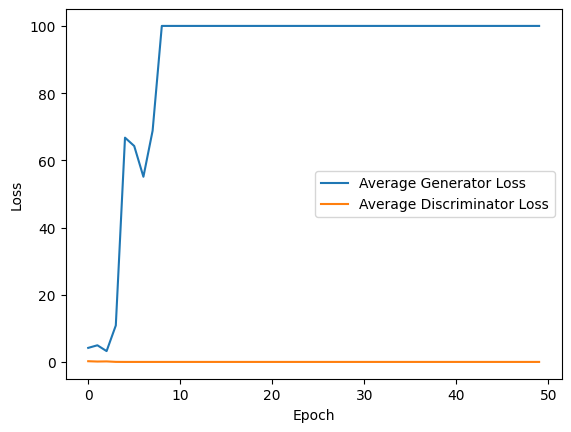

In [ ]:
# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_generator = optim.Adam(generator.parameters(), lr=lr_generator, betas=(adam_beta1, adam_beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(adam_beta1, adam_beta2))

def extra_gradient_update(model, loss, optimizer, lr, inputs, targets, other_model = None):
    # Compute the first set of gradients
    optimizer.zero_grad()
    grads_t = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    # Perform the first update: X_{t+1/2} = X_t - lr * grads_t
    for param, grad_t in zip(model.parameters(), grads_t):
        param.data = param.data - lr * grad_t

    if not other_model:
        # Compute the second set of gradients using the updated parameters
        loss_t1 = loss_function(model(inputs), targets)  # Update with your actual inputs and targets
    else:
        generated_samples = model(latent_space_samples)
        output_discriminator_generated = other_model(generated_samples)
        loss_t1 = loss_function(output_discriminator_generated, real_samples_labels)
    grads_t1 = torch.autograd.grad(loss_t1, model.parameters(), create_graph=True)

    # Perform the second update: X_{t+1} = X_t - lr * grads_{t+1/2}
    for param, grad_t1 in zip(model.parameters(), grads_t1):
        param.grad = grad_t1

    optimizer.step()


from tqdm import tqdm

# Lists to store losses
average_generator_losses = []
average_discriminator_losses = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    generator_epoch_losses = []
    discriminator_epoch_losses = []

    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)

        # Extra-Gradient update for discriminator
        extra_gradient_update(discriminator, loss_discriminator, optimizer_discriminator, lr, all_samples, all_samples_labels)

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)

        # Extra-Gradient update for generator
        extra_gradient_update(generator, loss_generator, optimizer_generator, lr, latent_space_samples, real_samples_labels, discriminator)

        # Append losses to epoch lists
        generator_epoch_losses.append(loss_generator.item())
        discriminator_epoch_losses.append(loss_discriminator.item())

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

    # Average losses over the epoch
    average_generator_loss = sum(generator_epoch_losses) / len(generator_epoch_losses)
    average_discriminator_loss = sum(discriminator_epoch_losses) / len(discriminator_epoch_losses)

    # Append average losses to lists
    average_generator_losses.append(average_generator_loss)
    average_discriminator_losses.append(average_discriminator_loss)

# Plot average losses
plt.plot(average_generator_losses, label='Average Generator Loss')
plt.plot(average_discriminator_losses, label='Average Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the parameters of the generator
torch.save(generator.state_dict(), 'generator_2.pth')

# Save the parameters of the discriminator
torch.save(discriminator.state_dict(), 'discriminator_2.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 Loss D.: 0.6383851170539856
Epoch: 0 Loss G.: 0.8380497097969055


  2%|▏         | 1/50 [00:27<22:39, 27.74s/it]

Epoch: 1 Loss D.: 0.03815295919775963
Epoch: 1 Loss G.: 6.331608772277832


  4%|▍         | 2/50 [00:55<22:10, 27.72s/it]

Epoch: 2 Loss D.: 0.000641987775452435
Epoch: 2 Loss G.: 8.805116653442383


  6%|▌         | 3/50 [01:23<21:45, 27.78s/it]

Epoch: 3 Loss D.: 1.9553119727788726e-06
Epoch: 3 Loss G.: 15.036458969116211


  8%|▊         | 4/50 [01:51<21:21, 27.86s/it]

Epoch: 4 Loss D.: 2.3343975610510236e-14
Epoch: 4 Loss G.: 39.871253967285156


 10%|█         | 5/50 [02:19<20:55, 27.91s/it]

Epoch: 5 Loss D.: 1.2055682295416528e-16
Epoch: 5 Loss G.: 50.93586730957031


 12%|█▏        | 6/50 [02:47<20:31, 27.99s/it]

Epoch: 6 Loss D.: 1.4176732726481929e-24
Epoch: 6 Loss G.: 68.36637878417969


 14%|█▍        | 7/50 [03:15<19:59, 27.90s/it]

Epoch: 7 Loss D.: 2.3242147713806516e-24
Epoch: 7 Loss G.: 71.63058471679688


 16%|█▌        | 8/50 [03:43<19:32, 27.92s/it]

Epoch: 8 Loss D.: 1.7980528372641732e-19
Epoch: 8 Loss G.: 67.60316467285156


 18%|█▊        | 9/50 [04:10<19:03, 27.89s/it]

Epoch: 9 Loss D.: 2.858497964552953e-06
Epoch: 9 Loss G.: 56.81447982788086


 20%|██        | 10/50 [04:38<18:34, 27.85s/it]

Epoch: 10 Loss D.: 9.313227522511625e-09
Epoch: 10 Loss G.: 98.18087005615234


 22%|██▏       | 11/50 [05:06<18:09, 27.92s/it]

Epoch: 11 Loss D.: 0.0001076124535757117
Epoch: 11 Loss G.: 14.229290008544922


 24%|██▍       | 12/50 [05:34<17:40, 27.91s/it]

Epoch: 12 Loss D.: 4.200529929221375e-06
Epoch: 12 Loss G.: 42.08917236328125


 26%|██▌       | 13/50 [06:02<17:11, 27.87s/it]

Epoch: 13 Loss D.: 5.6456039601471275e-05
Epoch: 13 Loss G.: 12.520429611206055


 28%|██▊       | 14/50 [06:30<16:43, 27.87s/it]

Epoch: 14 Loss D.: 5.067410029369057e-07
Epoch: 14 Loss G.: 23.180938720703125


 30%|███       | 15/50 [06:58<16:17, 27.93s/it]

Epoch: 15 Loss D.: 7.056939466565382e-06
Epoch: 15 Loss G.: 23.878421783447266


 32%|███▏      | 16/50 [07:26<15:52, 28.03s/it]

Epoch: 16 Loss D.: 1.7831089849096315e-07
Epoch: 16 Loss G.: 35.39466094970703


 34%|███▍      | 17/50 [07:54<15:22, 27.97s/it]

Epoch: 17 Loss D.: 5.40224327494343e-08
Epoch: 17 Loss G.: 34.878089904785156


 36%|███▌      | 18/50 [08:22<14:54, 27.94s/it]

Epoch: 18 Loss D.: 5.840080063990172e-08
Epoch: 18 Loss G.: 32.265380859375


 38%|███▊      | 19/50 [08:50<14:26, 27.95s/it]

Epoch: 19 Loss D.: 2.5632805773057044e-05
Epoch: 19 Loss G.: 27.826515197753906


 40%|████      | 20/50 [09:18<13:58, 27.95s/it]

Epoch: 20 Loss D.: 1.1460090831860725e-07
Epoch: 20 Loss G.: 31.393993377685547


 42%|████▏     | 21/50 [09:46<13:29, 27.90s/it]

Epoch: 21 Loss D.: 3.725304509316629e-08
Epoch: 21 Loss G.: 50.38835144042969


 44%|████▍     | 22/50 [10:13<13:01, 27.92s/it]

Epoch: 22 Loss D.: 1.8709018778650943e-09
Epoch: 22 Loss G.: 55.758460998535156


 46%|████▌     | 23/50 [10:42<12:36, 28.01s/it]

Epoch: 23 Loss D.: 5.107257498859763e-12
Epoch: 23 Loss G.: 59.29051971435547


 48%|████▊     | 24/50 [11:10<12:09, 28.05s/it]

Epoch: 24 Loss D.: 1.4901166522918174e-08
Epoch: 24 Loss G.: 88.44087219238281


 50%|█████     | 25/50 [11:38<11:40, 28.01s/it]

Epoch: 25 Loss D.: 6.037324300607443e-28
Epoch: 25 Loss G.: 79.90394592285156


 52%|█████▏    | 26/50 [12:06<11:13, 28.04s/it]

Epoch: 26 Loss D.: 1.6473055269520138e-22
Epoch: 26 Loss G.: 81.4937744140625


 54%|█████▍    | 27/50 [12:34<10:44, 28.01s/it]

Epoch: 27 Loss D.: 1.9210308799429143e-13
Epoch: 27 Loss G.: 74.87060546875


 56%|█████▌    | 28/50 [13:02<10:18, 28.12s/it]

Epoch: 28 Loss D.: 9.418202539200875e-15
Epoch: 28 Loss G.: 73.48350524902344


 58%|█████▊    | 29/50 [13:30<09:49, 28.09s/it]

Epoch: 29 Loss D.: 0.0
Epoch: 29 Loss G.: 98.35401153564453


 60%|██████    | 30/50 [13:58<09:22, 28.11s/it]

Epoch: 30 Loss D.: 3.694208406604212e-21
Epoch: 30 Loss G.: 96.17558288574219


 62%|██████▏   | 31/50 [14:27<08:54, 28.12s/it]

Epoch: 31 Loss D.: 1.389409001567555e-15
Epoch: 31 Loss G.: 92.7505111694336


 64%|██████▍   | 32/50 [14:55<08:26, 28.13s/it]

Epoch: 32 Loss D.: 8.293634695638647e-24
Epoch: 32 Loss G.: 97.42825317382812


 66%|██████▌   | 33/50 [15:23<07:57, 28.10s/it]

Epoch: 33 Loss D.: 5.846095238494098e-34
Epoch: 33 Loss G.: 98.70204162597656


 68%|██████▊   | 34/50 [15:51<07:29, 28.09s/it]

Epoch: 34 Loss D.: 1.667331907714812e-30
Epoch: 34 Loss G.: 98.2957763671875


 70%|███████   | 35/50 [16:19<07:01, 28.08s/it]

Epoch: 35 Loss D.: 1.5628792531245305e-36
Epoch: 35 Loss G.: 97.71239471435547


 72%|███████▏  | 36/50 [16:47<06:32, 28.06s/it]

Epoch: 36 Loss D.: 0.0
Epoch: 36 Loss G.: 99.61248779296875


 74%|███████▍  | 37/50 [17:15<06:04, 28.02s/it]

Epoch: 37 Loss D.: 1.3514428962663445e-33
Epoch: 37 Loss G.: 99.09214782714844


 76%|███████▌  | 38/50 [17:43<05:36, 28.06s/it]

Epoch: 38 Loss D.: 1.3214160440675165e-37
Epoch: 38 Loss G.: 95.94123840332031


 78%|███████▊  | 39/50 [18:12<05:10, 28.22s/it]

Epoch: 39 Loss D.: 9.773963400145105e-32
Epoch: 39 Loss G.: 99.39460754394531


 80%|████████  | 40/50 [18:40<04:41, 28.16s/it]

Epoch: 40 Loss D.: 0.0
Epoch: 40 Loss G.: 98.3742904663086


 82%|████████▏ | 41/50 [19:08<04:14, 28.29s/it]

Epoch: 41 Loss D.: 4.5537399892220265e-35
Epoch: 41 Loss G.: 98.10549926757812


 84%|████████▍ | 42/50 [19:36<03:46, 28.31s/it]

Epoch: 42 Loss D.: 0.0
Epoch: 42 Loss G.: 100.0


 86%|████████▌ | 43/50 [20:04<03:17, 28.17s/it]

Epoch: 43 Loss D.: 0.0
Epoch: 43 Loss G.: 100.0


 88%|████████▊ | 44/50 [20:32<02:48, 28.12s/it]

Epoch: 44 Loss D.: 0.0
Epoch: 44 Loss G.: 100.0


 90%|█████████ | 45/50 [21:00<02:20, 28.04s/it]

Epoch: 45 Loss D.: 0.0
Epoch: 45 Loss G.: 100.0


 92%|█████████▏| 46/50 [21:29<01:52, 28.12s/it]

Epoch: 46 Loss D.: 0.0
Epoch: 46 Loss G.: 100.0


 94%|█████████▍| 47/50 [21:57<01:24, 28.15s/it]

Epoch: 47 Loss D.: 0.0
Epoch: 47 Loss G.: 100.0


 96%|█████████▌| 48/50 [22:25<00:56, 28.08s/it]

Epoch: 48 Loss D.: 0.0
Epoch: 48 Loss G.: 100.0


 98%|█████████▊| 49/50 [22:53<00:28, 28.10s/it]

Epoch: 49 Loss D.: 0.0
Epoch: 49 Loss G.: 100.0


100%|██████████| 50/50 [23:21<00:00, 28.03s/it]


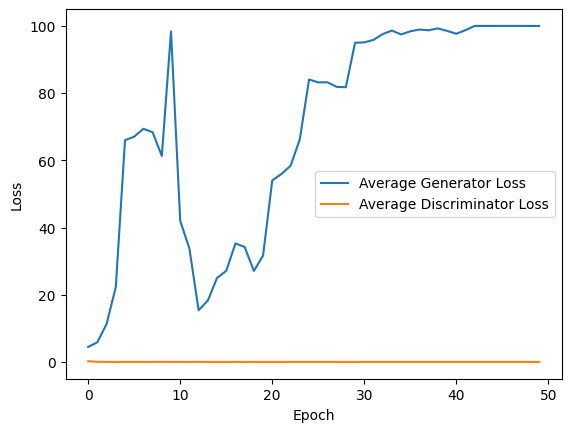

In [ ]:
# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_generator = optim.Adam(generator.parameters(), lr=lr_generator, betas=(adam_beta1, adam_beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(adam_beta1, adam_beta2))

def extra_gradient_update(model, loss, optimizer, lr, inputs, targets, other_model = None):
    # Compute the first set of gradients
    optimizer.zero_grad()
    grads_t = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    # Perform the first update: X_{t+1/2} = X_t - lr * grads_t
    for param, grad_t in zip(model.parameters(), grads_t):
        param.data = param.data - lr * grad_t

    if not other_model:
        # Compute the second set of gradients using the updated parameters
        loss_t1 = loss_function(model(inputs), targets)  # Update with your actual inputs and targets
    else:
        generated_samples = model(latent_space_samples)
        output_discriminator_generated = other_model(generated_samples)
        loss_t1 = loss_function(output_discriminator_generated, real_samples_labels)
    grads_t1 = torch.autograd.grad(loss_t1, model.parameters(), create_graph=True)

    # Perform the second update: X_{t+1} = X_t - lr * grads_{t+1/2}
    for param, grad_t1 in zip(model.parameters(), grads_t1):
        param.grad = grad_t1

    optimizer.step()


from tqdm import tqdm

# Lists to store losses
average_generator_losses = []
average_discriminator_losses = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    generator_epoch_losses = []
    discriminator_epoch_losses = []

    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)

        # Extra-Gradient update for discriminator
        extra_gradient_update(discriminator, loss_discriminator, optimizer_discriminator, lr, all_samples, all_samples_labels)

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Append losses to epoch lists
        generator_epoch_losses.append(loss_generator.item())
        discriminator_epoch_losses.append(loss_discriminator.item())

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

    # Average losses over the epoch
    average_generator_loss = sum(generator_epoch_losses) / len(generator_epoch_losses)
    average_discriminator_loss = sum(discriminator_epoch_losses) / len(discriminator_epoch_losses)

    # Append average losses to lists
    average_generator_losses.append(average_generator_loss)
    average_discriminator_losses.append(average_discriminator_loss)

# Plot average losses
plt.plot(average_generator_losses, label='Average Generator Loss')
plt.plot(average_discriminator_losses, label='Average Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the parameters of the generator
torch.save(generator.state_dict(), 'generator_3.pth')

# Save the parameters of the discriminator
torch.save(discriminator.state_dict(), 'discriminator_3.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 Loss D.: 0.6406805515289307
Epoch: 0 Loss G.: 0.8738996982574463


  2%|▏         | 1/50 [00:29<24:09, 29.57s/it]

Epoch: 1 Loss D.: 0.03698600083589554
Epoch: 1 Loss G.: 28.11663055419922


  4%|▍         | 2/50 [00:58<23:26, 29.29s/it]

Epoch: 2 Loss D.: 0.5287994742393494
Epoch: 2 Loss G.: 13.733980178833008


  6%|▌         | 3/50 [01:28<23:04, 29.45s/it]

Epoch: 3 Loss D.: 0.0003769455070141703
Epoch: 3 Loss G.: 9.613889694213867


  8%|▊         | 4/50 [01:57<22:34, 29.44s/it]

Epoch: 4 Loss D.: 0.00020853927708230913
Epoch: 4 Loss G.: 8.399112701416016


 10%|█         | 5/50 [02:27<22:07, 29.49s/it]

Epoch: 5 Loss D.: 3.434574225025244e-08
Epoch: 5 Loss G.: 20.022560119628906


 12%|█▏        | 6/50 [02:56<21:39, 29.53s/it]

Epoch: 6 Loss D.: 2.9745953963877803e-12
Epoch: 6 Loss G.: 33.68659973144531


 14%|█▍        | 7/50 [03:26<21:10, 29.55s/it]

Epoch: 7 Loss D.: 3.2098260681345803e-13
Epoch: 7 Loss G.: 47.817543029785156


 16%|█▌        | 8/50 [03:56<20:46, 29.67s/it]

Epoch: 8 Loss D.: 2.7446320495170224e-36
Epoch: 8 Loss G.: 95.90550231933594


 18%|█▊        | 9/50 [04:26<20:18, 29.72s/it]

Epoch: 9 Loss D.: 1.624449639063992e-21
Epoch: 9 Loss G.: 89.75960540771484


 20%|██        | 10/50 [04:55<19:47, 29.69s/it]

Epoch: 10 Loss D.: 3.730691090390796e-22
Epoch: 10 Loss G.: 84.5326156616211


 22%|██▏       | 11/50 [05:25<19:19, 29.72s/it]

Epoch: 11 Loss D.: 6.338816369079379e-25
Epoch: 11 Loss G.: 85.84524536132812


 24%|██▍       | 12/50 [05:55<18:48, 29.70s/it]

Epoch: 12 Loss D.: 2.923625211267989e-28
Epoch: 12 Loss G.: 82.71802520751953


 26%|██▌       | 13/50 [06:24<18:17, 29.65s/it]

Epoch: 13 Loss D.: 4.452224452845186e-25
Epoch: 13 Loss G.: 87.67881774902344


 28%|██▊       | 14/50 [06:54<17:44, 29.56s/it]

Epoch: 14 Loss D.: 2.6430684481072892e-27
Epoch: 14 Loss G.: 83.95744323730469


 30%|███       | 15/50 [07:25<17:30, 30.01s/it]

Epoch: 15 Loss D.: 5.522971582963788e-27
Epoch: 15 Loss G.: 88.39434814453125


 32%|███▏      | 16/50 [07:56<17:09, 30.29s/it]

Epoch: 16 Loss D.: 5.3265209083719345e-12
Epoch: 16 Loss G.: 89.01506805419922


 34%|███▍      | 17/50 [08:25<16:34, 30.12s/it]

Epoch: 17 Loss D.: 1.8194693518863704e-27
Epoch: 17 Loss G.: 86.12438201904297


 36%|███▌      | 18/50 [08:55<15:56, 29.88s/it]

Epoch: 18 Loss D.: 5.908551909849208e-25
Epoch: 18 Loss G.: 76.46024322509766


 38%|███▊      | 19/50 [09:24<15:24, 29.81s/it]

Epoch: 19 Loss D.: 5.929242252278958e-24
Epoch: 19 Loss G.: 78.60943603515625


 40%|████      | 20/50 [09:54<14:49, 29.65s/it]

Epoch: 20 Loss D.: 0.0
Epoch: 20 Loss G.: 100.0


 42%|████▏     | 21/50 [10:23<14:17, 29.57s/it]

Epoch: 21 Loss D.: 1.105195566445847e-15
Epoch: 21 Loss G.: 91.8729248046875


 44%|████▍     | 22/50 [10:53<13:48, 29.59s/it]

Epoch: 22 Loss D.: 5.5368116545332155e-34
Epoch: 22 Loss G.: 98.13381958007812


 46%|████▌     | 23/50 [11:22<13:15, 29.48s/it]

Epoch: 23 Loss D.: 0.0
Epoch: 23 Loss G.: 100.0


 48%|████▊     | 24/50 [11:51<12:45, 29.44s/it]

Epoch: 24 Loss D.: 0.0
Epoch: 24 Loss G.: 100.0


 50%|█████     | 25/50 [12:21<12:16, 29.47s/it]

Epoch: 25 Loss D.: 0.0
Epoch: 25 Loss G.: 100.0


 52%|█████▏    | 26/50 [12:50<11:44, 29.35s/it]

Epoch: 26 Loss D.: 0.0
Epoch: 26 Loss G.: 100.0


 54%|█████▍    | 27/50 [13:19<11:12, 29.22s/it]

Epoch: 27 Loss D.: 0.0
Epoch: 27 Loss G.: 100.0


 56%|█████▌    | 28/50 [13:48<10:41, 29.16s/it]

Epoch: 28 Loss D.: 0.0
Epoch: 28 Loss G.: 100.0


 58%|█████▊    | 29/50 [14:16<10:09, 29.01s/it]

Epoch: 29 Loss D.: 0.0
Epoch: 29 Loss G.: 100.0


 60%|██████    | 30/50 [14:46<09:41, 29.06s/it]

Epoch: 30 Loss D.: 0.0
Epoch: 30 Loss G.: 100.0


 62%|██████▏   | 31/50 [15:15<09:11, 29.04s/it]

Epoch: 31 Loss D.: 0.0
Epoch: 31 Loss G.: 100.0


 64%|██████▍   | 32/50 [15:44<08:42, 29.02s/it]

Epoch: 32 Loss D.: 0.0
Epoch: 32 Loss G.: 100.0


 66%|██████▌   | 33/50 [16:13<08:15, 29.16s/it]

Epoch: 33 Loss D.: 0.0
Epoch: 33 Loss G.: 100.0


 68%|██████▊   | 34/50 [16:42<07:44, 29.03s/it]

Epoch: 34 Loss D.: 0.0
Epoch: 34 Loss G.: 100.0


 70%|███████   | 35/50 [17:11<07:14, 28.95s/it]

Epoch: 35 Loss D.: 0.0
Epoch: 35 Loss G.: 100.0


 72%|███████▏  | 36/50 [17:40<06:45, 28.95s/it]

Epoch: 36 Loss D.: 0.0
Epoch: 36 Loss G.: 100.0


 74%|███████▍  | 37/50 [18:08<06:15, 28.91s/it]

Epoch: 37 Loss D.: 3.5162120184395462e-06
Epoch: 37 Loss G.: 21.179351806640625


 76%|███████▌  | 38/50 [18:37<05:47, 28.94s/it]

Epoch: 38 Loss D.: 3.8749038822061266e-07
Epoch: 38 Loss G.: 31.541643142700195


 78%|███████▊  | 39/50 [19:06<05:18, 28.96s/it]

Epoch: 39 Loss D.: 0.001672495505772531
Epoch: 39 Loss G.: 36.331016540527344


 80%|████████  | 40/50 [19:35<04:49, 28.96s/it]

Epoch: 40 Loss D.: 2.3020015760266688e-07
Epoch: 40 Loss G.: 59.917144775390625


 82%|████████▏ | 41/50 [20:05<04:21, 29.08s/it]

Epoch: 41 Loss D.: 1.8626460374093767e-08
Epoch: 41 Loss G.: 92.64385223388672


 84%|████████▍ | 42/50 [20:34<03:52, 29.04s/it]

Epoch: 42 Loss D.: 5.587936335871291e-09
Epoch: 42 Loss G.: 93.00325012207031


 86%|████████▌ | 43/50 [21:03<03:23, 29.06s/it]

Epoch: 43 Loss D.: 5.442088877316564e-06
Epoch: 43 Loss G.: 100.0


 88%|████████▊ | 44/50 [21:32<02:54, 29.12s/it]

Epoch: 44 Loss D.: 3.725290742551124e-09
Epoch: 44 Loss G.: 99.53359985351562


 90%|█████████ | 45/50 [22:01<02:26, 29.20s/it]

Epoch: 45 Loss D.: 3.725290742551124e-09
Epoch: 45 Loss G.: 100.0


 92%|█████████▏| 46/50 [22:30<01:56, 29.13s/it]

Epoch: 46 Loss D.: 1.117587533627784e-08
Epoch: 46 Loss G.: 99.30059814453125


 94%|█████████▍| 47/50 [23:00<01:27, 29.17s/it]

Epoch: 47 Loss D.: 3.952460409520649e-40
Epoch: 47 Loss G.: 100.0


 96%|█████████▌| 48/50 [23:29<00:58, 29.20s/it]

Epoch: 48 Loss D.: 0.0
Epoch: 48 Loss G.: 100.0


 98%|█████████▊| 49/50 [23:59<00:29, 29.33s/it]

Epoch: 49 Loss D.: 8.235052724251582e-40
Epoch: 49 Loss G.: 100.0


100%|██████████| 50/50 [24:28<00:00, 29.38s/it]


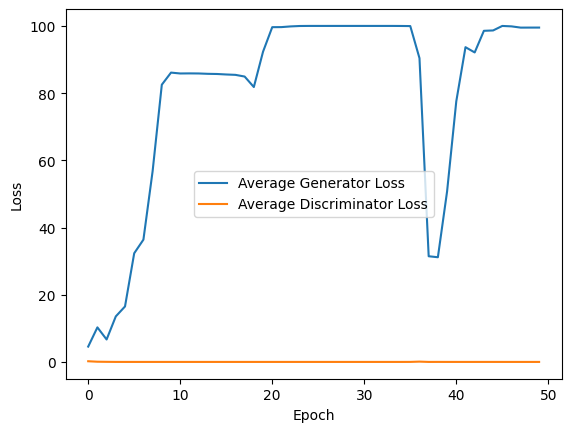

In [ ]:
# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_generator = optim.Adam(generator.parameters(), lr=lr_generator, betas=(adam_beta1, adam_beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(adam_beta1, adam_beta2))

def extra_gradient_update(model, loss, optimizer, lr, inputs, targets, other_model = None):
    # Compute the first set of gradients
    optimizer.zero_grad()
    grads_t = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    # Perform the first update: X_{t+1/2} = X_t - lr * grads_t
    for param, grad_t in zip(model.parameters(), grads_t):
        param.data = param.data - lr * grad_t

    if not other_model:
        # Compute the second set of gradients using the updated parameters
        loss_t1 = loss_function(model(inputs), targets)  # Update with your actual inputs and targets
    else:
        generated_samples = model(latent_space_samples)
        output_discriminator_generated = other_model(generated_samples)
        loss_t1 = loss_function(output_discriminator_generated, real_samples_labels)
    grads_t1 = torch.autograd.grad(loss_t1, model.parameters(), create_graph=True)

    # Perform the second update: X_{t+1} = X_t - lr * grads_{t+1/2}
    for param, grad_t1 in zip(model.parameters(), grads_t1):
        param.grad = grad_t1

    optimizer.step()


from tqdm import tqdm

# Lists to store losses
average_generator_losses = []
average_discriminator_losses = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    generator_epoch_losses = []
    discriminator_epoch_losses = []

    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)

        # Extra-Gradient update for generator
        extra_gradient_update(generator, loss_generator, optimizer_generator, lr, latent_space_samples, real_samples_labels, discriminator)

        # Append losses to epoch lists
        generator_epoch_losses.append(loss_generator.item())
        discriminator_epoch_losses.append(loss_discriminator.item())

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

    # Average losses over the epoch
    average_generator_loss = sum(generator_epoch_losses) / len(generator_epoch_losses)
    average_discriminator_loss = sum(discriminator_epoch_losses) / len(discriminator_epoch_losses)

    # Append average losses to lists
    average_generator_losses.append(average_generator_loss)
    average_discriminator_losses.append(average_discriminator_loss)

# Plot average losses
plt.plot(average_generator_losses, label='Average Generator Loss')
plt.plot(average_discriminator_losses, label='Average Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 Loss D.: 0.6657758951187134
Epoch: 0 Loss G.: 0.8641856908798218


  2%|▏         | 1/50 [00:30<25:01, 30.65s/it]

Epoch: 1 Loss D.: 0.08066204190254211
Epoch: 1 Loss G.: 5.053153038024902


  4%|▍         | 2/50 [00:57<22:44, 28.42s/it]

Epoch: 2 Loss D.: 0.0648188665509224
Epoch: 2 Loss G.: 4.538352966308594


  6%|▌         | 3/50 [01:23<21:33, 27.52s/it]

Epoch: 3 Loss D.: 5.194544883124763e-07
Epoch: 3 Loss G.: 18.992549896240234


  8%|▊         | 4/50 [01:50<20:55, 27.29s/it]

Epoch: 4 Loss D.: 2.788535311992746e-05
Epoch: 4 Loss G.: 61.744300842285156


 10%|█         | 5/50 [02:17<20:20, 27.12s/it]

Epoch: 5 Loss D.: 8.717422588233603e-07
Epoch: 5 Loss G.: 53.083091735839844


 12%|█▏        | 6/50 [02:44<19:48, 27.00s/it]

Epoch: 6 Loss D.: 1.615408080729681e-36
Epoch: 6 Loss G.: 99.00979614257812


 14%|█▍        | 7/50 [03:11<19:17, 26.93s/it]

Epoch: 7 Loss D.: 2.40571232586142e-35
Epoch: 7 Loss G.: 100.0


 16%|█▌        | 8/50 [03:37<18:47, 26.84s/it]

Epoch: 8 Loss D.: 3.808268075525825e-36
Epoch: 8 Loss G.: 99.5437240600586


 18%|█▊        | 9/50 [04:04<18:18, 26.80s/it]

Epoch: 9 Loss D.: 0.0
Epoch: 9 Loss G.: 98.8414535522461


 20%|██        | 10/50 [04:31<17:50, 26.76s/it]

Epoch: 10 Loss D.: 1.4171322849822212e-36
Epoch: 10 Loss G.: 99.52577209472656


 22%|██▏       | 11/50 [04:58<17:24, 26.79s/it]

Epoch: 11 Loss D.: 8.658638905605845e-37
Epoch: 11 Loss G.: 99.01826477050781


 24%|██▍       | 12/50 [05:24<16:55, 26.74s/it]

Epoch: 12 Loss D.: 1.9860227811094948e-36
Epoch: 12 Loss G.: 98.91043090820312


 26%|██▌       | 13/50 [05:51<16:30, 26.78s/it]

Epoch: 13 Loss D.: 9.153761194197686e-36
Epoch: 13 Loss G.: 93.93223571777344


 28%|██▊       | 14/50 [06:18<16:01, 26.70s/it]

Epoch: 14 Loss D.: 6.451821679346938e-30
Epoch: 14 Loss G.: 93.34515380859375


 30%|███       | 15/50 [06:45<15:36, 26.75s/it]

Epoch: 15 Loss D.: 2.271516349771922e-31
Epoch: 15 Loss G.: 96.86380004882812


 32%|███▏      | 16/50 [07:12<15:13, 26.86s/it]

Epoch: 16 Loss D.: 9.100079965999138e-33
Epoch: 16 Loss G.: 94.16767883300781


 34%|███▍      | 17/50 [07:38<14:46, 26.86s/it]

Epoch: 17 Loss D.: 3.0547392431930285e-32
Epoch: 17 Loss G.: 93.38297271728516


 36%|███▌      | 18/50 [08:05<14:18, 26.82s/it]

Epoch: 18 Loss D.: 3.3103709874620774e-33
Epoch: 18 Loss G.: 94.69200134277344


 38%|███▊      | 19/50 [08:32<13:50, 26.80s/it]

Epoch: 19 Loss D.: 2.0790432263696236e-33
Epoch: 19 Loss G.: 89.95590209960938


 40%|████      | 20/50 [08:59<13:24, 26.82s/it]

Epoch: 20 Loss D.: 3.441383711333401e-08
Epoch: 20 Loss G.: 24.876127243041992


 42%|████▏     | 21/50 [09:26<12:57, 26.81s/it]

Epoch: 21 Loss D.: 1.045988938130904e-05
Epoch: 21 Loss G.: 17.11406707763672


 44%|████▍     | 22/50 [09:53<12:32, 26.87s/it]

Epoch: 22 Loss D.: 1.3238124665804207e-05
Epoch: 22 Loss G.: 15.72770881652832


 46%|████▌     | 23/50 [10:19<12:04, 26.83s/it]

Epoch: 23 Loss D.: 4.529319267021492e-05
Epoch: 23 Loss G.: 16.08719253540039


 48%|████▊     | 24/50 [10:46<11:37, 26.83s/it]

Epoch: 24 Loss D.: 7.623861506544927e-07
Epoch: 24 Loss G.: 22.49106216430664


 50%|█████     | 25/50 [11:13<11:10, 26.84s/it]

Epoch: 25 Loss D.: 9.511215637303394e-08
Epoch: 25 Loss G.: 24.5898494720459


 52%|█████▏    | 26/50 [11:40<10:44, 26.84s/it]

Epoch: 26 Loss D.: 4.1267174566428366e-08
Epoch: 26 Loss G.: 26.48193359375


 54%|█████▍    | 27/50 [12:07<10:18, 26.88s/it]

Epoch: 27 Loss D.: 8.885933198143903e-07
Epoch: 27 Loss G.: 24.285463333129883


 56%|█████▌    | 28/50 [12:34<09:50, 26.85s/it]

Epoch: 28 Loss D.: 4.674574029195355e-06
Epoch: 28 Loss G.: 22.919307708740234


 58%|█████▊    | 29/50 [13:01<09:25, 26.93s/it]

Epoch: 29 Loss D.: 1.9173736406249474e-18
Epoch: 29 Loss G.: 50.36886215209961


 60%|██████    | 30/50 [13:28<08:58, 26.90s/it]

Epoch: 30 Loss D.: 9.754263369243787e-14
Epoch: 30 Loss G.: 45.895957946777344


 62%|██████▏   | 31/50 [13:55<08:32, 26.99s/it]

Epoch: 31 Loss D.: 2.0394676344872437e-14
Epoch: 31 Loss G.: 47.642539978027344


 64%|██████▍   | 32/50 [14:21<08:03, 26.88s/it]

Epoch: 32 Loss D.: 1.9820055969718697e-14
Epoch: 32 Loss G.: 40.150596618652344


 66%|██████▌   | 33/50 [14:48<07:37, 26.93s/it]

Epoch: 33 Loss D.: 1.862713316924669e-09
Epoch: 33 Loss G.: 40.415916442871094


 68%|██████▊   | 34/50 [15:15<07:10, 26.94s/it]

Epoch: 34 Loss D.: 1.2582945482005753e-14
Epoch: 34 Loss G.: 43.47107696533203


 70%|███████   | 35/50 [15:42<06:43, 26.89s/it]

Epoch: 35 Loss D.: 2.89771592137944e-12
Epoch: 35 Loss G.: 44.51729965209961


 72%|███████▏  | 36/50 [16:09<06:16, 26.90s/it]

Epoch: 36 Loss D.: 3.574366011454248e-16
Epoch: 36 Loss G.: 51.05687713623047


 74%|███████▍  | 37/50 [16:36<05:48, 26.83s/it]

Epoch: 37 Loss D.: 9.721060969436663e-17
Epoch: 37 Loss G.: 51.30762481689453


 76%|███████▌  | 38/50 [17:03<05:22, 26.89s/it]

Epoch: 38 Loss D.: 1.7159764928442733e-11
Epoch: 38 Loss G.: 47.173133850097656


 78%|███████▊  | 39/50 [17:30<04:55, 26.88s/it]

Epoch: 39 Loss D.: 9.538820242648125e-16
Epoch: 39 Loss G.: 47.099525451660156


 80%|████████  | 40/50 [17:57<04:29, 26.91s/it]

Epoch: 40 Loss D.: 3.449969536864981e-18
Epoch: 40 Loss G.: 49.75237274169922


 82%|████████▏ | 41/50 [18:23<04:01, 26.83s/it]

Epoch: 41 Loss D.: 3.460686643977583e-19
Epoch: 41 Loss G.: 52.07891845703125


 84%|████████▍ | 42/50 [18:50<03:34, 26.85s/it]

Epoch: 42 Loss D.: 1.3771469919417816e-27
Epoch: 42 Loss G.: 97.06869506835938


 86%|████████▌ | 43/50 [19:17<03:07, 26.83s/it]

Epoch: 43 Loss D.: 4.423487550384629e-38
Epoch: 43 Loss G.: 98.38231658935547


 88%|████████▊ | 44/50 [19:44<02:40, 26.77s/it]

Epoch: 44 Loss D.: 1.0425166241319976e-35
Epoch: 44 Loss G.: 99.2577133178711


 90%|█████████ | 45/50 [20:10<02:13, 26.74s/it]

Epoch: 45 Loss D.: 9.963654686778824e-33
Epoch: 45 Loss G.: 99.04373168945312


 92%|█████████▏| 46/50 [20:37<01:46, 26.73s/it]

Epoch: 46 Loss D.: 0.0
Epoch: 46 Loss G.: 97.8203125


 94%|█████████▍| 47/50 [21:04<01:20, 26.75s/it]

Epoch: 47 Loss D.: 0.0
Epoch: 47 Loss G.: 99.22918701171875


 96%|█████████▌| 48/50 [21:31<00:53, 26.76s/it]

Epoch: 48 Loss D.: 8.949199888086401e-14
Epoch: 48 Loss G.: 97.96310424804688


 98%|█████████▊| 49/50 [21:58<00:26, 26.83s/it]

Epoch: 49 Loss D.: 1.1987261484769298e-35
Epoch: 49 Loss G.: 99.0080795288086


100%|██████████| 50/50 [22:24<00:00, 26.89s/it]


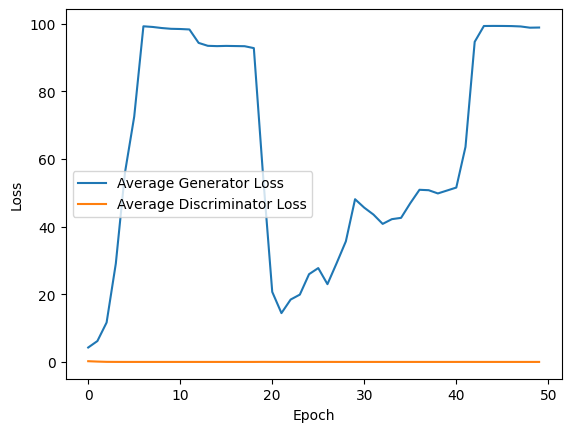

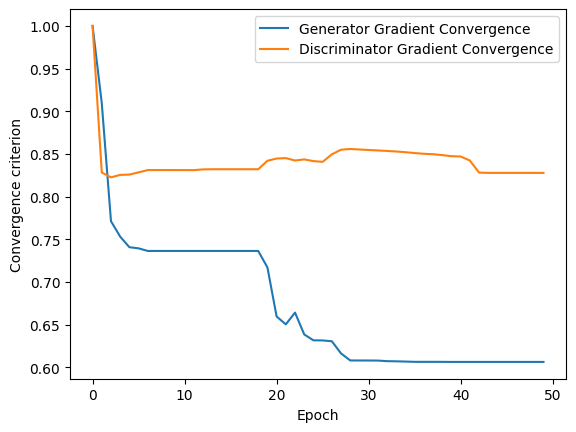

In [ ]:
import numpy as np

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_generator = optim.Adam(generator.parameters(), lr=lr_generator, betas=(adam_beta1, adam_beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(adam_beta1, adam_beta2))

def past_extra_gradient_update(model, loss, optimizer, lr, inputs, targets, old_grad = None,other_model = None):
    # Compute the first set of gradients
    optimizer.zero_grad()

    # Perform the first update: X_{t+1/2} = X_t - lr * grads_t
    if not old_grad:
        grads_t = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        for param, grad_t in zip(model.parameters(), grads_t):
            param.data = param.data - lr * grad_t
    else:
        for param, grad_t in zip(model.parameters(), old_grad):
            param.data = param.data - lr * grad_t

    if not other_model:
        # Compute the second set of gradients using the updated parameters
        loss_t1 = loss_function(model(inputs), targets)  # Update with your actual inputs and targets
    else:
        generated_samples = model(latent_space_samples)
        output_discriminator_generated = other_model(generated_samples)
        loss_t1 = loss_function(output_discriminator_generated, real_samples_labels)
    grads_t1 = torch.autograd.grad(loss_t1, model.parameters(), create_graph=True)

    # Perform the second update: X_{t+1} = X_t - lr * grads_{t+1/2}
    for param, grad_t1 in zip(model.parameters(), grads_t1):
        param.grad = grad_t1

    optimizer.step()

    return grads_t1


from tqdm import tqdm

# Lists to store losses
average_generator_losses = []
average_discriminator_losses = []
convergence_generator = []
convergence_discriminator = []
zero_grad_discriminator = None
zero_grad_generator = None

# Training loop
for epoch in tqdm(range(num_epochs)):
    generator_epoch_losses = []
    discriminator_epoch_losses = []
    old_grad = None
    grad_discriminator = None
    grad_generator = None

    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        if not grad_discriminator:
            grad_discriminator = [param for param in discriminator.parameters()]
        else:
            for i in range(len(grad_discriminator)):
                grad_discriminator[i] = grad_discriminator[i] + list(discriminator.parameters())[i]

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)

        # Extra-Gradient update for generator
        old_grad = past_extra_gradient_update(generator, loss_generator, optimizer_generator, lr, latent_space_samples, real_samples_labels, old_grad, discriminator)

        if not grad_generator:
            grad_generator = [param for param in generator.parameters()]
        else:
            for i in range(len(grad_generator)):
                grad_generator[i] = grad_generator[i] + list(generator.parameters())[i]
        # Append losses to epoch lists
        generator_epoch_losses.append(loss_generator.item())
        discriminator_epoch_losses.append(loss_discriminator.item())

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

    # Average losses over the epoch
    average_generator_loss = sum(generator_epoch_losses) / len(generator_epoch_losses)
    average_discriminator_loss = sum(discriminator_epoch_losses) / len(discriminator_epoch_losses)

    # Average gradients over the epoch
    average_grad_generator = [grad / len(generator_epoch_losses) for grad in grad_generator]
    average_grad_discriminator = [grad / len(discriminator_epoch_losses) for grad in grad_discriminator]

    if not zero_grad_discriminator:
        zero_grad_discriminator = average_grad_discriminator
        zero_grad_generator = average_grad_generator

    grads_ratio_discriminator = [torch.norm(grad1)/torch.norm(grad2) for grad1, grad2 in zip(zero_grad_discriminator, average_grad_discriminator)]
    grads_ratio_generator = [torch.norm(grad1)/torch.norm(grad2) for grad1, grad2 in zip(zero_grad_generator, average_grad_generator)]

    convergence_generator.append(sum(grads_ratio_generator) / len(grads_ratio_generator))
    convergence_discriminator.append(sum(grads_ratio_discriminator) / len(grads_ratio_discriminator))

    # Append average losses to lists
    average_generator_losses.append(average_generator_loss)
    average_discriminator_losses.append(average_discriminator_loss)

# Plot average losses
plt.plot(average_generator_losses, label='Average Generator Loss')
plt.plot(average_discriminator_losses, label='Average Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot gradient convergence
plt.plot([grad.cpu().detach().numpy() for grad in convergence_generator], label='Generator Gradient Convergence')
plt.plot([grad.cpu().detach().numpy() for grad in convergence_discriminator], label='Discriminator Gradient Convergence')
plt.xlabel('Epoch')
plt.ylabel('Convergence criterion')
plt.legend()
plt.show()

In [ ]:
# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_generator = optim.Adam(generator.parameters(), lr=lr_generator, betas=(adam_beta1, adam_beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(adam_beta1, adam_beta2))

def reflected_gradient_update(model, loss, optimizer, lr, inputs, targets, old_x = None,other_model = None):
    # Compute the first set of gradients
    optimizer.zero_grad()

    # Perform the first update: X_{t+1/2} = X_t - lr * grads_t
    if old_x is None or torch.isnan(old_x).any():
        grads_t = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        for param, grad_t in zip(model.parameters(), grads_t):
            param.data = param.data - lr * grad_t
    else:
        for param, x_val in zip(model.parameters(), old_x):
            param.data = param.data - (x_val - param.data)

    if not other_model:
        # Compute the second set of gradients using the updated parameters
        loss_t1 = loss_function(model(inputs), targets)  # Update with your actual inputs and targets
    else:
        generated_samples = model(latent_space_samples)
        output_discriminator_generated = other_model(generated_samples)
        loss_t1 = loss_function(output_discriminator_generated, real_samples_labels)
    grads_t1 = torch.autograd.grad(loss_t1, model.parameters(), create_graph=True)

    # Perform the second update: X_{t+1} = X_t - lr * grads_{t+1/2}
    for param, grad_t1 in zip(model.parameters(), grads_t1):
        param.grad = grad_t1

    optimizer.step()

    return param.data


from tqdm import tqdm

# Lists to store losses
average_generator_losses = []
average_discriminator_losses = []
convergence_generator = []
convergence_discriminator = []
zero_grad_discriminator = None
zero_grad_generator = None

# Training loop
for epoch in tqdm(range(num_epochs)):
    generator_epoch_losses = []
    discriminator_epoch_losses = []
    old_x = None
    grad_discriminator = None
    grad_generator = None

    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        if not grad_discriminator:
            grad_discriminator = [param for param in discriminator.parameters()]
        else:
            for i in range(len(grad_discriminator)):
                grad_discriminator[i] = grad_discriminator[i] + list(discriminator.parameters())[i]

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)

        # Extra-Gradient update for generator
        old_x = reflected_gradient_update(generator, loss_generator, optimizer_generator, lr, latent_space_samples, real_samples_labels, old_x, discriminator)

        if not grad_generator:
            grad_generator = [param for param in generator.parameters()]
        else:
            for i in range(len(grad_generator)):
                grad_generator[i] = grad_generator[i] + list(generator.parameters())[i]
        # Append losses to epoch lists
        generator_epoch_losses.append(loss_generator.item())
        discriminator_epoch_losses.append(loss_discriminator.item())

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

    # Average losses over the epoch
    average_generator_loss = sum(generator_epoch_losses) / len(generator_epoch_losses)
    average_discriminator_loss = sum(discriminator_epoch_losses) / len(discriminator_epoch_losses)

    # Average gradients over the epoch
    average_grad_generator = [grad / len(generator_epoch_losses) for grad in grad_generator]
    average_grad_discriminator = [grad / len(discriminator_epoch_losses) for grad in grad_discriminator]

    if not zero_grad_discriminator:
        zero_grad_discriminator = average_grad_discriminator
        zero_grad_generator = average_grad_generator

    grads_ratio_discriminator = [torch.norm(grad1)/torch.norm(grad2) for grad1, grad2 in zip(zero_grad_discriminator, average_grad_discriminator)]
    grads_ratio_generator = [torch.norm(grad1)/torch.norm(grad2) for grad1, grad2 in zip(zero_grad_generator, average_grad_generator)]

    convergence_generator.append(sum(grads_ratio_generator) / len(grads_ratio_generator))
    convergence_discriminator.append(sum(grads_ratio_discriminator) / len(grads_ratio_discriminator))

    # Append average losses to lists
    average_generator_losses.append(average_generator_loss)
    average_discriminator_losses.append(average_discriminator_loss)

# Plot average losses
plt.plot(average_generator_losses, label='Average Generator Loss')
plt.plot(average_discriminator_losses, label='Average Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot gradient convergence
plt.plot([grad.cpu().detach().numpy() for grad in convergence_generator], label='Generator Gradient Convergence')
plt.plot([grad.cpu().detach().numpy() for grad in convergence_discriminator], label='Discriminator Gradient Convergence')
plt.xlabel('Epoch')
plt.ylabel('Convergence criterion')
plt.legend()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 Loss D.: 0.009941893629729748
Epoch: 0 Loss G.: 4.247410297393799


  0%|          | 0/50 [00:02<?, ?it/s]


RuntimeError: ignored

In [9]:
import numpy as np

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_generator = optim.Adam(generator.parameters(), lr=lr_generator, betas=(adam_beta1, adam_beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(adam_beta1, adam_beta2))

def optimistic_gradient(model, loss, optimizer, lr, inputs, targets, old_grad = None,other_model = None):
    # Compute the first set of gradients
    optimizer.zero_grad()

    # Perform the first update: X_{t+1/2} = X_t - lr * grads_t
    if not old_grad:
        grads_t = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        for param, grad_t in zip(model.parameters(), grads_t):
            param.data = param.data - lr * grad_t
    else:
        for param, grad_t in zip(model.parameters(), old_grad):
            param.data = param.data - lr * grad_t

    if not other_model:
        # Compute the second set of gradients using the updated parameters
        loss_t1 = loss_function(model(inputs), targets)  # Update with your actual inputs and targets
    else:
        generated_samples = model(latent_space_samples)
        output_discriminator_generated = other_model(generated_samples)
        loss_t1 = loss_function(output_discriminator_generated, real_samples_labels)
    grads_t1 = torch.autograd.grad(loss_t1, model.parameters(), create_graph=True)
    if old_grad:
        grads_t1 = tuple(gt1 - gt0 for gt1, gt0 in zip(grads_t1, old_grad))

    for param, grad_t1 in zip(model.parameters(), grads_t1):
        param.grad = grad_t1

    optimizer.step()

    return grads_t1


from tqdm import tqdm

# Lists to store losses
average_generator_losses = []
average_discriminator_losses = []
convergence_generator = []
convergence_discriminator = []
zero_grad_discriminator = None
zero_grad_generator = None

# Training loop
for epoch in tqdm(range(num_epochs)):
    generator_epoch_losses = []
    discriminator_epoch_losses = []
    old_grad = None
    grad_discriminator = None
    grad_generator = None

    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        if not grad_discriminator:
            grad_discriminator = [param for param in discriminator.parameters()]
        else:
            for i in range(len(grad_discriminator)):
                grad_discriminator[i] = grad_discriminator[i] + list(discriminator.parameters())[i]

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)

        # Extra-Gradient update for generator
        old_grad = optimistic_gradient(generator, loss_generator, optimizer_generator, lr, latent_space_samples, real_samples_labels, old_grad, discriminator)

        if not grad_generator:
            grad_generator = [param for param in generator.parameters()]
        else:
            for i in range(len(grad_generator)):
                grad_generator[i] = grad_generator[i] + list(generator.parameters())[i]
        # Append losses to epoch lists
        generator_epoch_losses.append(loss_generator.item())
        discriminator_epoch_losses.append(loss_discriminator.item())

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

    # Average losses over the epoch
    average_generator_loss = sum(generator_epoch_losses) / len(generator_epoch_losses)
    average_discriminator_loss = sum(discriminator_epoch_losses) / len(discriminator_epoch_losses)

    # Average gradients over the epoch
    average_grad_generator = [grad / len(generator_epoch_losses) for grad in grad_generator]
    average_grad_discriminator = [grad / len(discriminator_epoch_losses) for grad in grad_discriminator]

    if not zero_grad_discriminator:
        zero_grad_discriminator = average_grad_discriminator
        zero_grad_generator = average_grad_generator

    grads_ratio_discriminator = [torch.norm(grad1)/torch.norm(grad2) for grad1, grad2 in zip(zero_grad_discriminator, average_grad_discriminator)]
    grads_ratio_generator = [torch.norm(grad1)/torch.norm(grad2) for grad1, grad2 in zip(zero_grad_generator, average_grad_generator)]

    convergence_generator.append(sum(grads_ratio_generator) / len(grads_ratio_generator))
    convergence_discriminator.append(sum(grads_ratio_discriminator) / len(grads_ratio_discriminator))

    # Append average losses to lists
    average_generator_losses.append(average_generator_loss)
    average_discriminator_losses.append(average_discriminator_loss)

# Plot average losses
plt.plot(average_generator_losses, label='Average Generator Loss')
plt.plot(average_discriminator_losses, label='Average Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot gradient convergence
plt.plot([grad.cpu().detach().numpy() for grad in convergence_generator], label='Generator Gradient Convergence')
plt.plot([grad.cpu().detach().numpy() for grad in convergence_discriminator], label='Discriminator Gradient Convergence')
plt.xlabel('Epoch')
plt.ylabel('Convergence criterion')
plt.legend()
plt.show()

OutOfMemoryError: ignored